In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB

### Read prepared keywords dataset from the csv file

In [ ]:
keywords_df = pd.DataFrame(pd.read_csv('../../../NLP_Patent_Project/keywords.tsv', sep=','))

In [ ]:
keywords_df.iloc[0]

### Read 2m prepared USPTO data

In [ ]:
df = pd.DataFrame(pd.read_csv('../USPTO-2M/uspto_2m.tsv', sep='\t'))

In [ ]:
#remove "US0" from No.
df['pid'] = df['No'].apply(lambda x: x[3:])

In [ ]:
df.head()

In [ ]:
#change the data type from the original keywords dataframe
keywords_df['pid'] = keywords_df['pid'].apply(lambda x: str(x))

### Collect keywords for 2m dataset only

In [ ]:
uspto_2m_patents_keywords_df = df.merge(keywords_df, left_on='pid', right_on='pid')

In [ ]:
uspto_2m_patents_keywords_df.head()

In [ ]:
info_list = []
for row in uspto_2m_patents_keywords_df.itertuples():
    label_list = row[1].replace("'", '').split(',')
    for label in label_list:
        info_list.append(tuple((label, row[2], row[3], row[4], row[5], row[6], row[7])))  #fast way
final_df = pd.DataFrame(info_list, columns=['label', 'Abstract', 'Title', 'pid', 'noun', 'verb', 'phrases'])

In [ ]:
final_df.to_csv('uspto_2m_keywords.tsv', index=False, sep='\t')

In [3]:
#for the notebook crash
label_words_df = pd.DataFrame(pd.read_csv('uspto_2m_keywords.tsv', sep='\t'))

### Remove invalid classes

In this section, remove invaild classes, only keep 631 valid classes. Also, these invalid classes do not have many patents.

In [3]:
label_words_df = label_words_df.drop(['Title'], axis = 1)
#label_words_df.head()

In [4]:
#check the detail of dataset
label_cnt = label_words_df.groupby('label')['pid'].count().reset_index().rename(columns={'pid':'count'})

In [5]:
label_cnt.describe()

,count
count,1256.000000
mean,2119.167197
std,9316.239709
min,1.000000
25%,92.750000
50%,332.500000
75%,1367.500000
max,261624.000000


In [6]:
#only half of classes have more than 300 patents
len(label_cnt[label_cnt['count'] > 300])

652

In [4]:
#read the valid list of classes
class_df = pd.DataFrame(pd.read_csv('ipc4_descriptions.csv', sep=','))
class_list = list(class_df['Class'])
print ('Number of classes: ', len(class_list))

Number of classes:  633


In [8]:
#the original data size
len(label_words_df)

2663397

In [5]:
#remove rows with invalid labels
sub_df = label_words_df[~label_words_df['label'].isin(class_list)]
len(sub_df)

678887

In [10]:
#check the detail of cleaned dataset
cleaned_label_cnt = sub_df.groupby('label')['pid'].count().reset_index().rename(columns={'pid':'count'})
cleaned_label_cnt.describe()

,count
count,630.000000
mean,1077.598413
std,3291.141742
min,1.000000
25%,68.250000
50%,230.500000
75%,798.250000
max,49814.000000


We see that the number of patents per class is imbalanced.

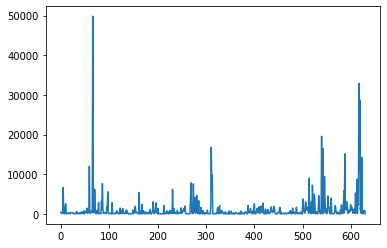

In [11]:
plt.plot(cleaned_label_cnt['count'])

### Create vocabulary

In [12]:
sub_df.head()

,label,Abstract,pid,noun,verb,phrases
1,H01L,an apparatus for generating a saddle shaped tr...,8536817,"apparatus, saddle, trajectory, intersection, c...","generate, shape, motorize, connect, intersect,...","two cylindrical conduit, motorize axial module..."
5,B65D,a container or tray having various features th...,8540111,"container, tray, feature, comprise, sidewall, ...","correspond, connect, mold, encapsulate, extend...","bottom surface, top surface, second region con..."
8,A61K,screening methods for identifying compounds an...,8481553,"compound, pharmaceutical, composition, cancer,...","screen, identify, treat, prevent, disclose, af...","signal transduction downstream, meet receptor ..."
10,H01L,methods of forming conductive pattern structur...,8476763,"pattern, structure, insulating, interlayer, su...","form, etch, extend, block, electroplate, polis...","disconnected shape, first second conductive pa..."
17,G07C,a method of logging information about events f...,8473149,"information, event, combustion, engine, igniti...","log, arrange, implement, comprise, incremente,...","least two field, ignition circuit, predetermin..."


In [6]:
def combineRows_column(col):
    return col.str.cat(sep=', ')
def removeDuplicateWords(words):
    return set(x.strip() for x in words.split(','))

In [7]:
#nouns = combineRows_column(sub_df['noun'])
#verbs = sub_df['verb'].str.cat(sep=', ')
phrases = combineRows_column(sub_df['phrases'])

In [8]:
#remove longer terms, and those including stopwords
def filterWords(len_words, words, stopwords):
    filtered_set = []
    for word in words:
        split_list = word.split(' ')
        if (len(split_list) <= len_words):
            no_stopwords = ' '.join([word for word in split_list if word not in stopwords])
            filtered_set.append(no_stopwords)
    return filtered_set

In [9]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

stopwords2 = ["a","about","above","after","again","against","ain","all","am","an","and","any","are","aren","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can","couldn","couldn't","d","did","didn","didn't","do","does","doesn","doesn't","doing","don","don't","down","during","each","few","for","from","further","had","hadn","hadn't","has","hasn","hasn't","have","haven","haven't","having","he","her","here","hers","herself","him","himself","his","how","i","if","in","into","is","isn","isn't","it","it's","its","itself","just","ll","m","ma","me","mightn","mightn't","more","most","mustn","mustn't","my","myself","needn","needn't","no","nor","not","now","o","of","off","on","once","only","or","other","our","ours","ourselves","out","over","own","re","s","same","shan","shan't","she","she's","should","should've","shouldn","shouldn't","so","some","such","t","than","that","that'll","the","their","theirs","them","themselves","then","there","these","they","this","those","through","to","too","under","until","up","ve","very","was","wasn","wasn't","we","were","weren","weren't","what","when","where","which","while","who","whom","why","will","with","won","won't","wouldn","wouldn't","y","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","could","he'd","he'll","he's","here's","how's","i'd","i'll","i'm","i've","let's","ought","she'd","she'll","that's","there's","they'd","they'll","they're","they've","we'd","we'll","we're","we've","what's","when's","where's","who's","why's","would","able","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","afterwards","ah","almost","alone","along","already","also","although","always","among","amongst","announce","another","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","arent","arise","around","aside","ask","asking","auth","available","away","awfully","b","back","became","become","becomes","becoming","beforehand","begin","beginning","beginnings","begins","behind","believe","beside","besides","beyond","biol","brief","briefly","c","ca","came","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","couldnt","date","different","done","downwards","due","e","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","ff","fifth","first","five","fix","followed","following","follows","former","formerly","forth","found","four","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","happens","hardly","hed","hence","hereafter","hereby","herein","heres","hereupon","hes","hi","hid","hither","home","howbeit","however","hundred","id","ie","im","immediate","immediately","importance","important","inc","indeed","index","information","instead","invention","inward","itd","it'll","j","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","made","mainly","make","makes","many","may","maybe","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","moreover","mostly","mr","mrs","much","mug","must","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","nobody","non","none","nonetheless","noone","normally","nos","noted","nothing","nowhere","obtain","obtained","obviously","often","oh","ok","okay","old","omitted","one","ones","onto","ord","others","otherwise","outside","overall","owing","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","said","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","shed","shes","show","showed","shown","showns","shows","significant","significantly","similar","similarly","since","six","slightly","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","sufficiently","suggest","sup","sure","take","taken","taking","tell","tends","th","thank","thanks","thanx","thats","that've","thence","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","theyd","theyre","think","thou","though","thoughh","thousand","throug","throughout","thru","thus","til","tip","together","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","unfortunately","unless","unlike","unlikely","unto","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","via","viz","vol","vols","vs","w","want","wants","wasnt","way","wed","welcome","went","werent","whatever","what'll","whats","whence","whenever","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","whim","whither","whod","whoever","whole","who'll","whomever","whos","whose","widely","willing","wish","within","without","wont","words","world","wouldnt","www","x","yes","yet","youd","youre","z","zero","a's","ain't","allow","allows","apart","appear","appreciate","appropriate","associated","best","better","c'mon","c's","cant","changes","clearly","concerning","consequently","consider","considering","corresponding","course","currently","definitely","described","despite","entirely","exactly","example","going","greetings","hello","help","hopefully","ignored","inasmuch","indicate","indicated","indicates","inner","insofar","it'd","keep","keeps","novel","presumably","reasonably","second","secondly","sensible","serious","seriously","sure","t's","third","thorough","thoroughly","three","well","wonder"]
stopwords = stopwords.words("english") + list(ENGLISH_STOP_WORDS) + stopwords2

def cleanDataSet(tag, df):
    words = combineRows_column(df[tag])
    words = removeDuplicateWords(words)
    words = filterWords(5, words, stopwords)
    print (tag, ' length: ', len(words))
    return words

In [11]:
#words = cleanDataSet('noun', sub_df)
words = cleanDataSet('phrases', sub_df)

phrases  length:  2096992


In [ ]:
#save to a txt file
with open('nouns.txt', 'w') as f:
    for p in cleaned_phrases_set:
        f.write(p +'\n')
f.close()

In [12]:
def getVocabulary(words_set):
    customize_vocabulary = {}
    idx = 0
    for word in words_set:
        if (word not in customize_vocabulary):
            customize_vocabulary[word] = idx
            idx += 1
    return customize_vocabulary

In [13]:
#from nouns
customize_vocabulary = getVocabulary(words)
len(customize_vocabulary)

1793245

### Generate tfidf vectorization according to the own vocabulary

In this section, we try different strategies:

1) We tried the original dataset, but the result shows that the accuracy is very low, like 0.16. This is because the original dataset is overly imbalanced, and we only used a small subset for training. Therefore, we randomly select samples for each class with the same size, in order to have a balanced dataset. Note that some classes may not have enough patents, so we allow duplicate patents appearing in the corresponding classes.

2) Only choose a small subset to test different classifiers. Vary sample size from 100 to 1000, the accuarcy is gradually increasing. Therefore, the accuracy should be better if choose a large patent dataset for traning.

3) Choose bag of phrases as the default vocabulary can get better results than bag of nouns.

In [14]:
sub_df = sub_df.dropna()

In [15]:
#choose fixed number of patents randomly
size = 1000        # sample size
replace = True  # cannot choose False, since some classes do not have 100 samples
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
test_df = sub_df.groupby('label', as_index=False).apply(fn)
y = test_df['label']
len(test_df)

630000

In [137]:
#keep the same distribution
# frac = 0.3
# grouped_df = sub_df.groupby('label')
# test_df = grouped_df.apply(lambda x: x.sample(n=round(len(x) * frac), random_state = 99, replace=True))
# test_df = test_df.reset_index(drop=True)
# y = test_df['label']
# len(test_df)

203215

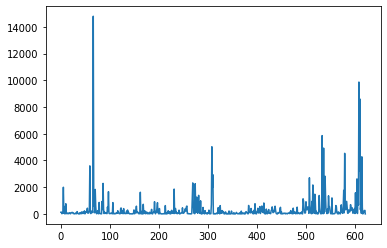

In [138]:
# plt.plot(test_df.groupby('label')['pid'].count().reset_index().rename(columns={'pid':'count'})['count'])

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import time

start_time = time.time()

dataset = test_df['Abstract']

tfidf_vectorizer = TfidfVectorizer(vocabulary=customize_vocabulary, ngram_range=(1,5))
tfidf_vectors = tfidf_vectorizer.fit_transform(dataset)

print("--- %s seconds ---" % (time.time() - start_time))

--- 232.8656907081604 seconds ---


In [17]:
tfidf_vectors.shape

(630000, 1793245)

### Classifiers

In [22]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_vectors, y, test_size = 0.2, random_state = 0)

In [23]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

#### Naive Bayes

In [34]:
#with default parameters, acc = 0.38
#acc is increasing when decreasing alpha
start_time = time.time()
nb = MultinomialNB(alpha=0.001, fit_prior=False)
model = nb.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 248.56410598754883 seconds ---


In [35]:
y_pred = model.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.7292857142857143


#### SVM with SGD training

In [29]:
from sklearn.linear_model import SGDClassifier

start_time = time.time()
sgd = SGDClassifier(n_jobs=4, random_state=99)
model = sgd.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

/Users/yan/anaconda3/envs/py3-tf2/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


--- 220.67724919319153 seconds ---


In [30]:
y_pred = model.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.6653412698412698


#### Linear SVM

In [36]:
from sklearn.svm import LinearSVC
start_time = time.time()
svc = LinearSVC()
model = svc.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1537.7343788146973 seconds ---


In [37]:
y_pred = model.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.7400396825396826


### Results

MultinomialNB: 0.729

LinearSVC: 0.740

SVM_SGD: 0.665

LinearSVC performs better than other two classifiers, even with sub dataset. To increase the number of patents per class will improve the performance. With the limitation of computer power, haven't tried Random Forests, Xgboost, Logistic Regression.

According to the classification report, the f1-score is better than some papers'. One reason might be we have balanced dataset, and removed the invalid classes.

Following work: 

1) Try other tranditional classification algorithms: Random Forests, Xgboost, Logistic Regression.

2) With BOW, tfidf matrix has very high dimension, can try feature selection methods (e.g., chi-2) to filter the features matrix, in order to reduce dimension.

3) Try GridSearch to fine tuning the algorithms.

In [38]:
#save the model first
from sklearn.externals import joblib
joblib_file = "tfidf_SVM_Model.pkl"  
joblib.dump(model, joblib_file)

['tfidf_SVM_Model.pkl']

In [45]:
conf_matrix = confusion_matrix(y_pred, y_test)
print (conf_matrix)

[[121   8   0 ...   0   0   0]
 [ 12 169   0 ...   0   0   0]
 [  8   0 188 ...   0   0   0]
 ...
 [  0   0   0 ... 123   0   0]
 [  0   0   0 ...   0  86   0]
 [  0   0   0 ...   0   0 179]]


In [52]:
#print(classification_report(y_test, y_pred, target_names=encoder.classes_))